# First things first
Click **File -> Save a copy in Drive** and click **Open in new tab** in the pop-up window to save your progress in Google Drive.

# Gaussian processes and Bayesian optimization

In this assignment you will learn how to use <a href="http://sheffieldml.github.io/GPy/">GPy</a> and <a href="http://sheffieldml.github.io/GPyOpt/">GPyOpt</a> libraries to deal with gaussian processes. These libraries provide quite simple and inuitive interfaces for training and inference, and we will try to get familiar with them in a few tasks.

### Setup
Load auxiliary files and then install and import the necessary libraries.

In [1]:
try:
    import google.colab
    IN_COLAB = True
except:
    IN_COLAB = False
if IN_COLAB:
    print("Downloading Colab files")
    ! shred -u setup_google_colab.py
    ! wget https://raw.githubusercontent.com/hse-aml/bayesian-methods-for-ml/master/setup_google_colab.py -O setup_google_colab.py
    import setup_google_colab
    setup_google_colab.load_data_week6()

In [2]:
import numpy as np
import GPy
import GPyOpt
import matplotlib.pyplot as plt
from sklearn.svm import SVR
import sklearn.datasets
from xgboost import XGBRegressor
from sklearn.model_selection import cross_val_score
import time
from w6_grader import GPGrader
%matplotlib inline

### Grading
We will create a grader instace below and use it to collect your answers. Note that these outputs will be stored locally inside grader and will be uploaded to platform only after running submiting function in the last part of this assignment. If you want to make partial submission, you can run that cell any time you want.

In [3]:
grader = GPGrader()

## Gaussian processes: GPy (<a href="http://pythonhosted.org/GPy/">documentation</a>)

We will start with a simple regression problem, for which we will try to fit a Gaussian Process with RBF kernel.

In [4]:
def generate_points(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.sin(X) + np.random.randn(n, 1) * noise_variance**0.5
    return X, y
    
def generate_noise(n=25, noise_variance=0.0036):
    np.random.seed(777)
    X = np.random.uniform(-3., 3., (n, 1))
    y = np.random.randn(n, 1) * noise_variance**0.5
    return X, y

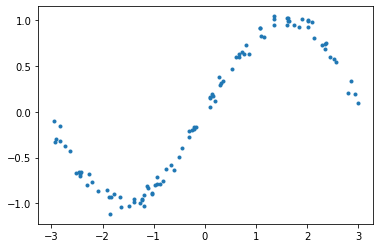

In [5]:
# Create data points
X, y = generate_points(n=100)
plt.plot(X, y, '.')
plt.show()

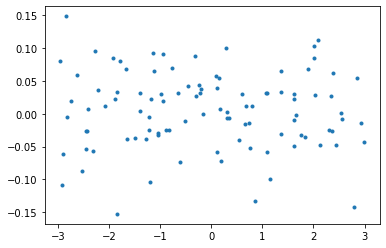

In [6]:
# Create data points
X, y = generate_noise(n=100)
plt.plot(X, y, '.')
plt.show()

To fit a Gaussian Process, you will need to define a kernel. For Gaussian (GBF) kernel you can use `GPy.kern.RBF` function.

<b> Task 1.1: </b> Create RBF kernel with variance 1.5 and length-scale parameter 2 for 1D samples and compute value of the kernel between points `X[5]` and `X[9]`. Submit a single number. 
<br><b>Hint:</b> use `.K` property of kernel object.

In [48]:
X, y = generate_points(n=25)

In [49]:
kernel = GPy.kern.RBF(1, variance=1.5, lengthscale=2)
kernel_59 = kernel.K(X[5].reshape(1, 1), X[9].reshape(1,1))
grader.submit_GPy_1(kernel_59)

Current answer for task 1.1 is: 1.0461813545396959


<b> Task 1.2: </b> Fit GP into generated data. Use kernel from previous task. Submit predicted mean and vairance at position $x=1$.
<br><b>Hint:</b> use `GPy.models.GPRegression` class.

In [50]:
model = GPy.models.GPRegression(X,y,kernel)
mean, variance = model.predict(np.array([[1]]))
grader.submit_GPy_2(mean, variance)

Current answer for task 1.2 (mean) is: 0.6646774926102937
Current answer for task 1.2 (variance) is: 1.100147822379058


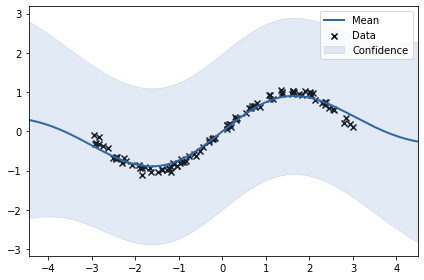

In [10]:
model.plot()
plt.show()

We see that the model didn't fit the data quite well. Let's try to fit kernel and noise parameters automatically as discussed in the lecture! You can see the current parameters below:

In [11]:
model

GP_regression.,value,constraints,priors
rbf.variance,1.5,+ve,
rbf.lengthscale,2.0,+ve,
Gaussian_noise.variance,1.0,+ve,


<b> Task 1.3: </b> Optimize length-scale, variance and noise component of the model and submit optimal length-scale value of the kernel. 
<br><b>Hint:</b> Use `.optimize()` function of the model and `.lengthscale` property of the kernel.

In [12]:
model.optimize()
lengthscale = kernel.lengthscale
grader.submit_GPy_3(lengthscale)

Current answer for task 1.3 is: 1.7529019842014413


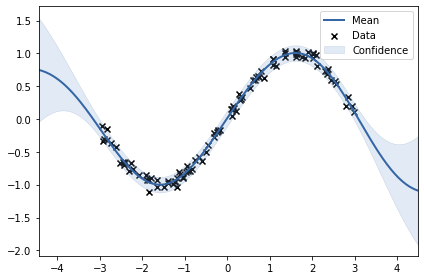

In [13]:
model.plot()
plt.show()

As you see, the process generates outputs just right. Let's see if GP can figure out itself when we try to fit it into noise or signal.

<b> Task 1.4: </b> Generate two datasets: sinusoid wihout noise and samples from gaussian noise. Optimize kernel parameters and submit optimal values of noise component.
<br><b>Note:</b> generate data only using ```generate_points(n, noise_variance)``` and ```generate_noise(n, noise_variance)``` function!

{'dataplot': [<matplotlib.collections.PathCollection at 0x102bcecc0>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x102bcec50>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x10181e320>]}

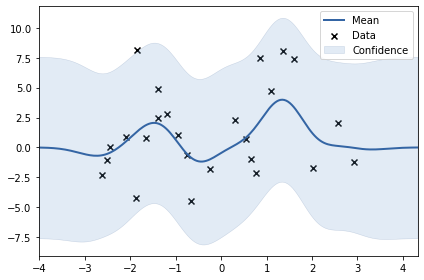

In [14]:
X, y = generate_noise(noise_variance=10)
model = GPy.models.GPRegression(X,y,kernel)
model.optimize()
noise = model.Gaussian_noise.variance
model.plot()

{'dataplot': [<matplotlib.collections.PathCollection at 0x12207b048>],
 'gpmean': [[<matplotlib.lines.Line2D at 0x12206af28>]],
 'gpconfidence': [<matplotlib.collections.PolyCollection at 0x12207b630>]}

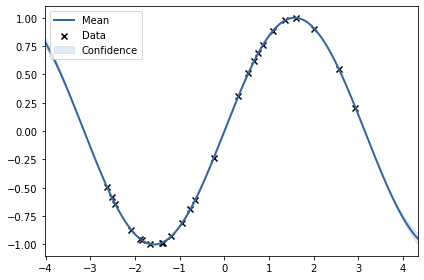

In [15]:
X, y = generate_points(noise_variance=0)
model = GPy.models.GPRegression(X,y,kernel)
model.optimize()
just_signal = model.Gaussian_noise.variance
model.plot()

In [16]:
grader.submit_GPy_4(noise, just_signal)

Current answer for task 1.4 (noise) is: 10.143335785499149
Current answer for task 1.4 (just signal) is: 1.4984188651828126e-14


## Sparse GP
Now let's consider the speed of GP. We will generate a dataset of 3000 points and measure the time that is consumed for prediction of mean and variance for each point. We will then try to use inducing inputs and find the optimal number of points according to quality-time tradeoff.

For the sparse model with inducing points, you should use ```GPy.models.SparseGPRegression``` class. You can set the number of inducing inputs with parameter ```num_inducing``` and optimize their positions and values with ```.optimize()``` call.

<b>Task 1.5</b>: Create a dataset of 1000 points and fit GPRegression. Measure time for predicting mean and variance at position $x=1$. Then fit `SparseGPRegression` with 10 inducing inputs and repeat the experiment. Report speedup as a ratio between consumed time without and with inducing inputs.

In [17]:
X, y = generate_points(1000)

In [18]:
start = time.time()
model = GPy.models.SparseGPRegression(X, y, num_inducing=3000)
model.optimize()
mean, variance = model.predict(np.array([[1]]))
time_gp = time.time()-start

In [19]:
time_gp

16.707154750823975

In [20]:
start = time.time()
model = GPy.models.SparseGPRegression(X, y, num_inducing=10)
model.optimize()
mean, variance = model.predict(np.array([[1]]))
time_sgp = time.time()-start

In [21]:
time_sgp

0.2864859104156494

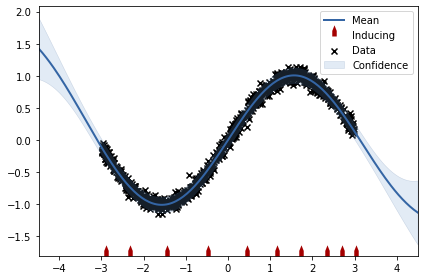

In [22]:
model.plot()
plt.show()

In [23]:
grader.submit_GPy_5(time_gp / time_sgp)

Current answer for task 1.5 is: 58.317544226116816


## Bayesian optimization: GPyOpt (<a href="http://pythonhosted.org/GPyOpt/">documentation</a>, <a href="http://nbviewer.jupyter.org/github/SheffieldML/GPyOpt/blob/master/manual/index.ipynb">tutorials</a>)

In this part of the assignment, we will try to find optimal hyperparameters to XGBoost model! We will use data from a small competition to speed things up, but keep in mind that the approach works even for large datasets.

We will use diabetes dataset provided in sklearn package.

In [24]:
dataset = sklearn.datasets.load_diabetes()
X = dataset['data']
y = dataset['target']

We will use cross-validation score to estimate accuracy and our goal will be to tune: ```max_depth```, ```learning_rate```, ```n_estimators``` parameters. The baseline MSE with default XGBoost parameters is $0.2$. Let's see if we can do better. First, we have to define optimization function and domains.

In [25]:
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def f(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        XGBRegressor(learning_rate=parameters[0],
                     max_depth=int(parameters[2]),
                     n_estimators=int(parameters[3]),
                     gamma=int(parameters[1]),
                     min_child_weight = parameters[4]), 
        X, y, scoring='neg_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score

In [26]:
baseline = -cross_val_score(
    XGBRegressor(), X, y, scoring='neg_mean_squared_error'
).mean()
baseline

3972.591068897167

In [27]:
# Bounds (NOTE: define continuous variables first, then discrete!)
bounds = [
    {'name': 'learning_rate',
     'type': 'continuous',
     'domain': (0, 1)},

    {'name': 'gamma',
     'type': 'continuous',
     'domain': (0, 5)},

    {'name': 'max_depth',
     'type': 'discrete',
     'domain': (1, 50)},

    {'name': 'n_estimators',
     'type': 'discrete',
     'domain': (1, 300)},

    {'name': 'min_child_weight',
     'type': 'discrete',
     'domain': (1, 10)}
]

In [28]:
np.random.seed(777)
optimizer = GPyOpt.methods.BayesianOptimization(
    f=f, domain=bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

In [29]:
max_iter = 50
max_time = 60
optimizer.run_optimization(max_iter, max_time)

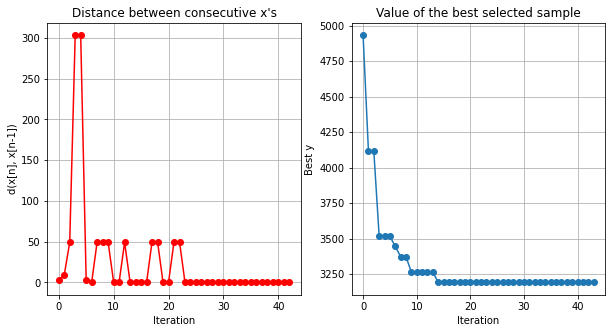

In [30]:
optimizer.plot_convergence()

Best values of parameters:

In [31]:
optimizer.X[np.argmin(optimizer.Y)]

array([9.16829074e-02, 1.89368774e+00, 1.00000000e+00, 3.00000000e+02,
       1.00000000e+00])

In [32]:
print('MSE:', np.min(optimizer.Y),
      'Gain:', baseline/np.min(optimizer.Y)*100)

MSE: 3191.6375666148524 Gain: 124.46874013676363


We were able to get 9% boost without tuning parameters by hand! Let's see if you can do the same. 

<b>Task 2.1:</b> Tune SVR model. Find optimal values for three parameters: `C`, `epsilon` and `gamma`. Use range (1e-5, 1000) for `C`, (1e-5, 10) for `epsilon` and `gamma`. Use MPI as an acquisition function with weight 0.1. Submit the optimal value of epsilon that was found by a model.

In [33]:
# Score. Optimizer will try to find minimum, so we will add a "-" sign.
def function_optimize(parameters):
    parameters = parameters[0]
    score = -cross_val_score(
        SVR(C=parameters[0], epsilon=parameters[1], gamma=parameters[2]), 
        X, y, scoring='neg_mean_squared_error'
    ).mean()
    score = np.array(score)
    return score

In [34]:
baseline = -cross_val_score(
    SVR(), X, y, scoring='neg_mean_squared_error'
).mean()
baseline

6067.652263997995

In [35]:
# Bounds (NOTE: define continuous variables first, then discrete!)
bounds = [
    {'name': 'regularization_parameter_c',
     'type': 'continuous',
     'domain': (1e-3, 1000)},

    {'name': 'epsilon',
     'type': 'continuous',
     'domain': (1e-3, 10)},

    {'name': 'gamma',
     'type': 'continuous',
     'domain': (1e-3, 10)}
]

In [36]:
np.random.seed(777)
optimizer_svr = GPyOpt.methods.BayesianOptimization(
    f=function_optimize, domain=bounds,
    acquisition_type ='MPI',
    acquisition_par = 0.1,
    exact_eval=True
)

In [37]:
max_iter = 100
max_time = 120
optimizer_svr.run_optimization(max_iter, max_time)

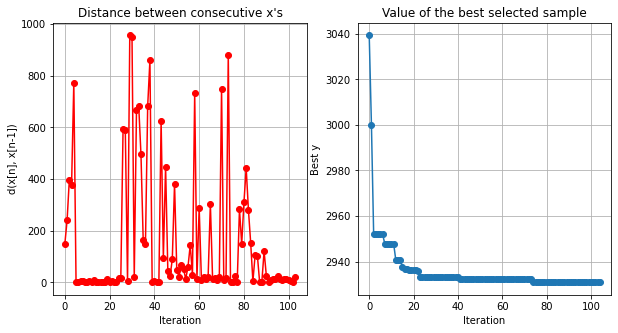

In [38]:
optimizer_svr.plot_convergence()

In [39]:
optimizer_svr.X.shape

(105, 3)

In [40]:
optimizer_svr.Y.shape

(105, 1)

In [41]:
x_best = optimizer_svr.X[np.argmin(optimizer_svr.Y)]
print("The best parameters obtained: C="+str(x_best[0])+", epilson="+str(x_best[1])+", gamma="+str(x_best[2]))

The best parameters obtained: C=49.07414779464113, epilson=5.847799523214346, gamma=10.0


In [42]:
print('MSE:', np.min(optimizer_svr.Y),
      'Gain:', baseline/np.min(optimizer_svr.Y)*100)

MSE: 2930.866184716741 Gain: 207.0259057079542


In [43]:
### YOUR CODE HERE
best_epsilon = x_best[1]
grader.submit_GPyOpt_1(best_epsilon)

Current answer for task 2.1 is: 5.847799523214346


<b>Task 2.2:</b> For the model above submit boost in improvement that you got after tuning hyperparameters (output percents) [e.g. if baseline MSE was 40 and you got 20, output number 200]

In [44]:
performance_boost = baseline/np.min(optimizer_svr.Y)*100
grader.submit_GPyOpt_2(performance_boost)

Current answer for task 2.2 is: 207.0259057079542


# Authorization & Submission
To submit assignment parts to Cousera platform, please, enter your e-mail and token into variables below. You can generate a token on this programming assignment's page. <b>Note:</b> The token expires 30 minutes after generation.

In [51]:
STUDENT_EMAIL = "espoir.mur@gmail.com"
STUDENT_TOKEN = "KaKZVX8HC85f9fRq"
grader.status()

You want to submit these numbers:
Task 1.1: 1.0461813545396959
Task 1.2 (mean): 0.6646774926102937
Task 1.2 (variance): 1.100147822379058
Task 1.3: 1.7529019842014413
Task 1.4 (noise): 10.143335785499149
Task 1.4 (just signal): 1.4984188651828126e-14
Task 1.5: 58.317544226116816
Task 2.1: 5.847799523214346
Task 2.2: 207.0259057079542


If you want to submit these answers, run cell below

In [52]:
grader.submit(STUDENT_EMAIL, STUDENT_TOKEN)

Submitted to Coursera platform. See results on assignment page!
